In [60]:
import numpy as np
import derivatives as der
import matplotlib.pyplot as plt

In [61]:
collision = np.load("2000keV-run_long-Collision.npz", allow_pickle=True)
C = collision['coll_nu']
Cbar = collision['coll_nubar']

data = np.load("2000keV-run_long.npz", allow_pickle=True)
settings = data['settings'].item()
raw = data['raw'].item()
nu3D = raw['nu3D']
nubar3D = raw['nubar3D']

T = settings['T']
dm2 = settings['delta m-squared']
theta = np.arcsin(np.sqrt(settings['sin^2 (2theta)']))/2
N = settings['N'] + 1
E = np.linspace(0,settings['eps_max'], N) * T
time = raw['time']
dt = raw['dt']

In [62]:
Cnorm = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        Cnorm[i,j] = np.linalg.norm(C[i,j,:])
        
Cbarnorm = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        Cbarnorm[i,j] = np.linalg.norm(Cbar[i,j,:])

In [63]:
def create_H(i,j):
    vacuum = der.vacuum(nu3D[i,j,:], E[j+1], dm2, theta)
    Vvv = der.Vvv_function(nu3D[i,:,:], E[1:]) - der.Vvv_function(nubar3D[i,:,:], E[1:])
    VTbar = der.VT_barfunction(nu3D[i,:,:], nubar3D[i,:,:], E[1:], T)
    
    return nu3D[i,j,0]* (vacuum + der.cross_product(nu3D[i,j,1:], Vvv) + der.cross_product(nu3D[i,j,1:], VTbar))

In [64]:
def create_Hbar(i,j):
    vacuum = der.vacuum(nubar3D[i,j,:], E[j+1], dm2, theta)
    Vvv = der.Vvv_function(nu3D[i,:,:], E[1:]) - der.Vvv_function(nubar3D[i,:,:], E[1:])
    VTbar = der.VT_barfunction(nu3D[i,:,:], nubar3D[i,:,:], E[1:], T)
    
    return nubar3D[i,j,0]* (-vacuum + der.cross_product(nubar3D[i,j,1:], Vvv) + der.cross_product(nubar3D[i,j,1:], VTbar))

In [65]:
H = np.zeros((len(time), N-1, 4))
for i in range(len(time)):
    for j in range(N-1):
        H[i,j,:] = create_H(i,j)
        
Hbar = np.zeros((len(time), N-1, 4))
for i in range(len(time)):
    for j in range(N-1):
        Hbar[i,j,:] = create_Hbar(i,j)

In [66]:
Hnorm = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        Hnorm[i,j] = np.linalg.norm(H[i,j,:])
        
Hbarnorm = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        Hbarnorm[i,j] = np.linalg.norm(Hbar[i,j,:])

In [67]:
magnitude_diffs = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        magnitude_diffs[i,j] = np.abs(Hnorm[i,j] - Cnorm[i,j])

magnitude_diffsbar = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        magnitude_diffsbar[i,j] = np.abs(np.linalg.norm(Hbar[i,j,:]) - Cbarnorm[i,j])

In [68]:
def energy_averaged(data):
    d = np.zeros(len(data))
    for i in range(len(data)):
        d[i] = np.linalg.norm(data[i,:])
    return d

In [69]:
def plot(c, y, title):
    fig = plt.figure(figsize=[4,3])
    color = plt.axes([0.1, 0, 1.00, 1.11])
    dens = plt.axes([0.1, 1.11, 1.00, 0.5])

    x = time
    dens.plot(x,y)
    dens.set_ylabel("number density/thermal distribution n_nu / n_{nu, th}")
    
    color.imshow(c[:,1:],origin='lower',aspect='auto',extent=(time[0], time[len(time)-1], E[0], E[len(E)-1]))
    color.set_ylabel("Energy")
    
    dens.xaxis.set_major_formatter(plt.NullFormatter())
    color.set_xlabel("Time")
    plt.title(title)

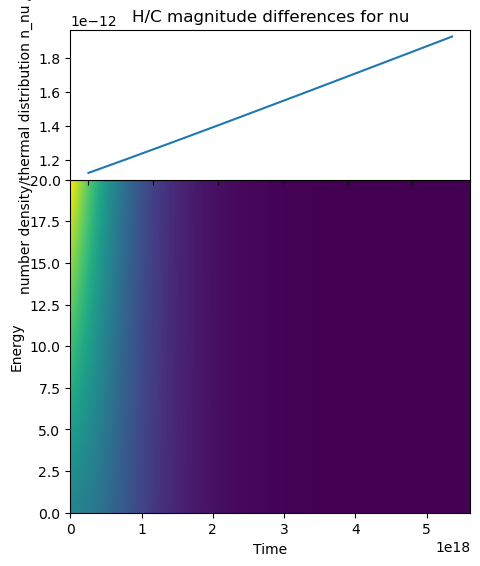

In [70]:
plot(magnitude_diffs, energy_averaged(Hnorm), "H/C magnitude differences for nu")

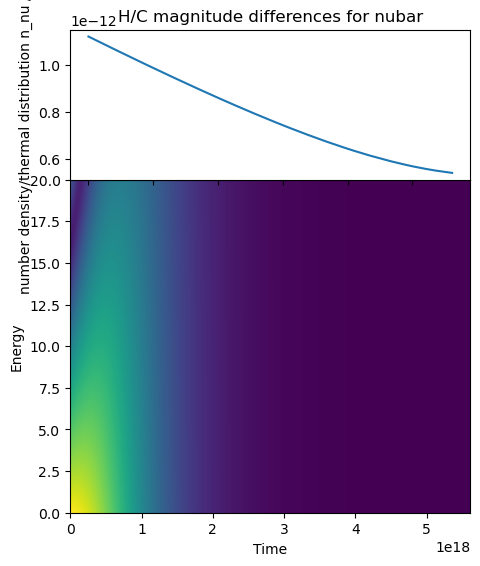

In [71]:
plot(magnitude_diffsbar, energy_averaged(Hbarnorm), "H/C magnitude differences for nubar")

In [72]:
theta = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        theta[i,j] = np.arccos(np.dot(H[i,j,1:], C[i,j,1:]) / (Hnorm[i,j] * Cnorm[i,j]))

In [73]:
thetabar = np.zeros((len(time), N-1))
for i in range(len(time)):
    for j in range(N-1):
        thetabar[i,j] = np.arccos(np.dot(Hbar[i,j,1:], Cbar[i,j,1:]) / (Hbarnorm[i,j] * Cbarnorm[i,j]))

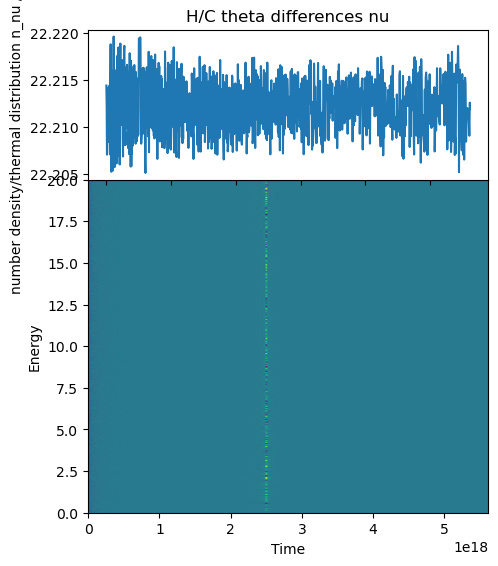

In [74]:
plot(theta, energy_averaged(theta), "H/C theta differences nu")

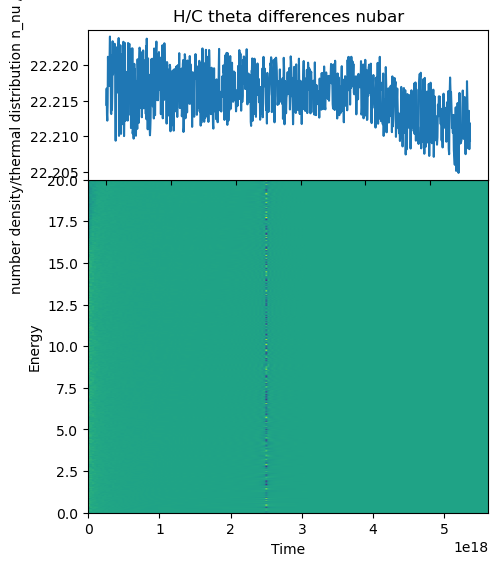

In [75]:
plot(thetabar, energy_averaged(thetabar), "H/C theta differences nubar")

In [76]:
# make a .npz file that contains Hvector, Cvector, Hbarvector, Cbar vector
# create (len(time), N-1, 4) array that contains next time data point by solving P0+dP0/dt*dt

In [81]:
nexttime_P = np.zeros((len(time), N-1,4))
for i in range(len(time)):
    for j in range(N-1):
        dPdt = 2*(H[i,j,:]+C[i,j,:])
        nexttime_P[i,j,:] = nu3D[i,j,:] + dPdt * dt[i]

In [82]:
nexttime_Pbar = np.zeros((len(time), N-1,4))
for i in range(len(time)):
    for j in range(N-1):
        dPbardt = 2*(Hbar[i,j,:]+Cbar[i,j,:])
        nexttime_Pbar[i,j,:] = nubar3D[i,j,:] + dPbardt * dt[i]

In [83]:
np.savez("H, C, next time arrays", H=H, Hbar=Hbar, C=C, Cbar=Cbar, t1P=nexttime_P, t1Pbar=nexttime_Pbar)

In [84]:
nexttime_P.shape

(957, 200, 4)